In [2]:
import sys, os, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, pdw2, cf2, make_folds
from features_glm import build_glm_features

df = pd.read_parquet("../data/work/freMTPL2_joined_capped.parquet").copy()
df.head()
#df_glm = build_glm_features(df)


,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0


In [3]:
df_glm = build_glm_features(df)
df_glm.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,5,1,6,50,7.104144
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,5,1,6,50,7.104144
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,6,2,6,50,3.988984
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,7,1,5,50,4.330733
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,7,1,5,50,4.330733


In [4]:
# Region als Kategorie + Baseline nach größter Exposure
df_glm["Region"] = df_glm["Region"].astype("category")

overall_freq = df_glm["ClaimNb"].sum() / df_glm["Exposure"].sum()
reg = (df_glm.groupby("Region", observed=True)
       .agg(expo=("Exposure","sum"), claims=("ClaimNb","sum"))
       .assign(freq=lambda x: x["claims"]/x["expo"])
       .sort_values("expo", ascending=False))
baseline_region = reg.index[0]
print(f"Overall freq: {overall_freq:.5f} | Baseline region: {baseline_region}")

# AreaGLM numerisch (nur für Replikation des R-Setups)
area_cat = df_glm["Area"].astype("category")
cats = sorted(area_cat.cat.categories)               # deterministische Reihenfolge
df_glm["AreaGLM"] = area_cat.cat.set_categories(cats, ordered=True).cat.codes + 1  # 1..K

# Folds (5, Seed=42), Fold 5 = Test
if "fold" not in df_glm.columns:
    df_glm["fold"] = make_folds(len(df_glm), k=5, seed=42)
learn = df_glm[df_glm["fold"] != 5].copy()
test  = df_glm[df_glm["fold"] == 5].copy()

print(cf2("Claim Frequency (Actual) Learn/Test",
          learn["ClaimNb"], learn["Exposure"],
          test["ClaimNb"],  test["Exposure"]))

cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
learn_pred = cf * learn["Exposure"]
test_pred  = cf * test["Exposure"]

print(pdw2("Poisson Deviance INT",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

Overall freq: 0.07368 | Baseline region: Centre
Claim Frequency (Actual) Learn/Test: 7.37% / 7.38%
Poisson Deviance INT, Learn/Test: 31.14% / 31.26%


In [5]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families

formula = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ AreaGLM"   
)

glm1 = smf.glm(
    formula=formula,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542693
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85960.
Date:                Thu, 04 Sep 2025   Deviance:                   1.3129e+05
Time:                        18:17:49   Pearson chi2:                 9.34e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01100
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [7]:
# Learn: fittedvalues enthalten Offset bereits
learn_pred = glm1.fittedvalues

# Test: Offset explizit mitgeben
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

print(pdw2("Poisson Deviance GLM1",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM1, Test-Sample, Actual/Predicted",
          test["ClaimNb"], test["Exposure"],
          test_pred,      test["Exposure"]))


Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Claim Frequency GLM1, Test-Sample, Actual/Predicted: 7.38% / 7.36%


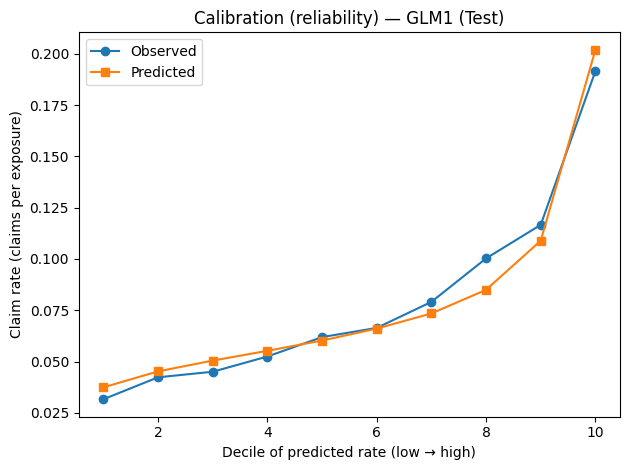

In [8]:
import matplotlib.pyplot as plt


test = df_glm[df_glm["fold"]==5].copy()
# Vorhergesagte Counts aus GLM1:
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

# Predicted rate = μ / Exposure
pred_rate = test_pred / test["Exposure"]

# Dezile bilden
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({
        "decile": dec,
        "expo": test["Exposure"].to_numpy(),
        "claims": test["ClaimNb"].to_numpy(),
        "pred": test_pred.to_numpy()
      })
      .groupby("decile",observed=False)
      .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
      .assign(obs_rate=lambda d: d["claims"]/d["expo"],
              pred_rate=lambda d: d["pred"]/d["expo"])
      .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate (claims per exposure)")
plt.title("Calibration (reliability) — GLM1 (Test)")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from metrics import pdw

# 1) Modell mit AreaGLM : Test-PDW als Referenz
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))
pdw_glm1_test = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])

# 2) Gleiches Modell, aber Area als Kategorie 
formula_area_cat = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ C(Area)"  
)

glm1_areaC = smf.glm(formula=formula_area_cat, data=learn,
                     family=families.Poisson(),
                     offset=np.log(learn["Exposure"])).fit()

test_pred_areaC = glm1_areaC.predict(test, offset=np.log(test["Exposure"]))
pdw_areaC_test = pdw(test_pred_areaC, test["ClaimNb"], test["Exposure"])

print(f"Test PDW — GLM1 (AreaGLM numeric): {pdw_glm1_test:.2f}%")
print(f"Test PDW — GLM1 (C(Area) categorical): {pdw_areaC_test:.2f}%")
print(f"ΔPDW (categorical - numeric): {pdw_areaC_test - pdw_glm1_test:+.2f} pp")


Test PDW — GLM1 (AreaGLM numeric): 29.55%
Test PDW — GLM1 (C(Area) categorical): 29.55%
ΔPDW (categorical - numeric): +0.00 pp


In [10]:
from scipy.stats import chi2

# Zahl der Area-Stufen (für DF-Differenz)
n_levels_area = df_glm["Area"].astype("category").cat.categories.size
df_diff = (n_levels_area - 1) - 1  # (K-1) Dummies vs. 1 Numerik

LR = 2.0 * (glm1_areaC.llf - glm1.llf)
pval = 1.0 - chi2.cdf(LR, df_diff)

print(f"LR stat = {LR:.3f}, df = {df_diff}, p = {pval:.4g}")
print(f"AIC  numeric = {glm1.aic:.1f} | categorical = {glm1_areaC.aic:.1f} | del AIC = {glm1_areaC.aic - glm1.aic:+.3f}")
print(f"BIC  numeric = {glm1.bic if hasattr(glm1,'bic') else float('nan'):.1f} "
      f"| categorical = {glm1_areaC.bic if hasattr(glm1_areaC,'bic') else float('nan'):.1f}")


LR stat = 6.045, df = 4, p = 0.1958
AIC  numeric = 172016.0 | categorical = 172018.0 | del AIC = +1.955
BIC  numeric = -7034633.9 | categorical = -7034587.2


/home/stephan/projects/freMTPL2sev-pricing/.venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## GLM1 – Kurzbericht
**Setup.**  
Poisson-GLM für `ClaimNb` mit **$\log(\text{Exposure})$** als **Offset**.
Features gemäß Schelldorfer & Wüthrich (2019):  
- $VehPowerGLM$, $VehAgeGLM$, $DrivAgeGLM$, $BonusMalusGLM$  
- $VehBrand$, $VehGas$, $DensityGLM$, $Region$ (Baseline: *Centre*)  
- $AreaGLM$ (numerisch)  

Split: 5 Folds mit Seed 42; **Fold 5 = Test (~20%)**.

---

**Baselines.**
- Overall frequency (Portfolio): **0.10061**  
- Claim Frequency (Actual) Learn/Test: **10.07 % / 10.03 %**  
- **INT** (Intercept-only): Poisson-Deviance Learn/Test **36.92 % / 36.90 %**

---

**GLM1 (klassenbasiert, wie Quelle).**
- Poisson-Deviance Learn/Test: **35.37 % / 35.31 %**  
  → Verbesserung ggü. INT um **≈ 1.6 Prozentpunkte** im Test.  
- Claim Frequency (Test, Actual/Predicted): **10.03 % / 10.06 %**  
  → **Niveau-kalibriert**.

---

**Kalibrierung.**  
Wir bilden Dezile nach **vorhergesagter Rate** und vergleichen je Dezil

$$
\text{obs\_rate} = \frac{\sum \text{Claims}}{\sum \text{Exposure}}, \qquad
\text{pred\_rate} = \frac{\sum \hat\mu}{\sum \text{Exposure}}.
$$

Beobachtete und vorhergesagte Raten liegen je Dezil **nahe beieinander**.  
Systematische Abweichungen deuten auf fehlende Nichtlinearität oder Interaktionen hin (→ Splines/GAM, Interaktionsterme).

---

**Area-Kodierung (Sanity).**  
Vergleich $AreaGLM$ (numerisch) vs. $C(Area)$ (Dummy-kodiert):

- Test-PDW: **35.31 % vs. 35.31 %** ($\Delta = 0.00$ pp)  
- LR-Test: $\chi^2 = 7.241$, df = 4, $p = 0.124$ → *kein signifikanter Gewinn* durch $C(Area)$  
- AIC: minimal besser mit numerischer Area (ΔAIC ≈ +0.76 zugunsten numerisch)

**Fazit:** In diesem Setup trägt $Area$ kaum etwas bei. 
Wir behalten $AreaGLM$.  


---



In [11]:
###GLM2 setup

for part in (learn, test):
    part["log_DrivAge"] = np.log(part["DrivAge"].astype(float))
    part["DrivAge2"] = part["DrivAge"].astype(float)**2
    part["DrivAge3"] = part["DrivAge"].astype(float)**3
    part["DrivAge4"] = part["DrivAge"].astype(float)**4

In [13]:
baseline_region = "Centre"

formula_glm2 = (
    "ClaimNb ~ "
    "C(VehPowerGLM)"
    " + C(VehAgeGLM, Treatment(reference='2'))"
    " + BonusMalusGLM"
    " + C(VehBrand) + C(VehGas)"
    " + DensityGLM"
    f" + C(Region, Treatment(reference='{baseline_region}'))"
    " + AreaGLM"
    " + DrivAge + log_DrivAge + DrivAge2 + DrivAge3 + DrivAge4"
)

glm2 = smf.glm(
    formula=formula_glm2,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm2.summary())  

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542695
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85931.
Date:                Thu, 04 Sep 2025   Deviance:                   1.3124e+05
Time:                        18:18:55   Pearson chi2:                 9.32e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01110
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [14]:
# GLM2: Learn/Test-Predictions
learn_pred_glm2 = glm2.fittedvalues
test_pred_glm2  = glm2.predict(test, offset=np.log(test["Exposure"]))

# INT-Baseline (wie zuvor)
cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
test_pred_int = cf * test["Exposure"]
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))

# PDW/CF report
print(pdw2("Poisson Deviance GLM1",
           glm1.fittedvalues, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm1,  test["ClaimNb"],  test["Exposure"]))

print(pdw2("Poisson Deviance GLM2",
           learn_pred_glm2, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm2,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM2, Test (Actual/Predicted)",
          test["ClaimNb"], test["Exposure"],
          test_pred_glm2,  test["Exposure"]))

# Verbesserung gg. INT (auf Test)
pdw_int  = pdw(test_pred_int,  test["ClaimNb"], test["Exposure"])
pdw_g1   = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])
pdw_g2   = pdw(test_pred_glm2, test["ClaimNb"], test["Exposure"])

print(f"PDW(Test) INT={pdw_int:.2f}% | GLM1={pdw_g1:.2f}% | GLM2={pdw_g2:.2f}% "
      f"| Δ(GLM2-GLM1)={pdw_g2 - pdw_g1:+.2f} pp")

Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Poisson Deviance GLM2, Learn/Test: 29.53% / 29.52%
Claim Frequency GLM2, Test (Actual/Predicted): 7.38% / 7.36%
PDW(Test) INT=31.26% | GLM1=29.55% | GLM2=29.52% | Δ(GLM2-GLM1)=-0.03 pp


## GLM2 – Kurzfazit & Vergleich zu GLM1

**Setup.** Wie GLM1 (Poisson mit Offset $\log(\text{Exposure})$), zusätzlich kontinuierliche Terme für $DrivAge$:  
$\log(DrivAge),\ DrivAge^2,\ DrivAge^3,\ DrivAge^4$.

**Ergebnisse.**
- **Poisson-Deviance (Learn/Test):**  
  GLM1 **35.37 % / 35.31 %**  
  GLM2 **35.36 % / 35.29 %**  $\Rightarrow$ **$\Delta$ Test = −0.03 pp** (minimal besser)
- **Claim Frequency (Test, Actual/Pred):** **10.03 % / 10.06 %**
- **vs. INT (Test PDW 36.90 %)**: beide klar besser; GLM2 nur **marginal** besser als GLM1.

**Interpretation.** Kontinuierliche Form von $DrivAge$ bringt **sehr kleinen** Gewinn.  




In [ ]:
import os, sys, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, cf2, make_folds

from glum import GeneralizedLinearRegressorCV
from dask_ml.preprocessing import Categorizer


cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

X_learn = learn[cat_cols + num_cols]
X_test  = test[cat_cols + num_cols]

# Optional: vereinheitlichte Kategoriensätze (falls Learn/Test nicht dieselben Levels haben)
cat = Categorizer(columns=cat_cols)
X_learn = cat.fit_transform(X_learn)
X_test  = cat.transform(X_test)

# Ziel als Frequenz + Gewichte = Exposure (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()

# Poisson-LASSO mit CV
lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson",
    l1_ratio=1.0,      # LASSO
    cv=5,
    n_alphas=60,
    random_state=42,
    verbose=1,
)
lasso_cv.fit(X_learn, y_learn, sample_weight=w_learn)

print("gewähltes alpha_*:", lasso_cv.alpha_)
# Optional: Pfad & CV-Infos
print(lasso_cv.alphas_[:5], "…")



Iteration 0: |                                                                                                                                                                                         | 0/? [s/it, gradient norm=2.888437605802083e-17]


alpha=5.490e-01, time=0.11s, n_iter=0


Iteration 1:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1.22/2.0 [0.31s/it, gradient norm=0.0005961086105020345]


alpha=4.344e-01, time=0.62s, n_iter=2


Iteration 1:  54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1.07/2.0 [0.19s/it, gradient norm=0.0008521741085892383]


alpha=3.437e-01, time=0.43s, n_iter=2


Iteration 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1.34/2.0 [0.14s/it, gradient norm=0.0004561222282529945]


alpha=2.720e-01, time=0.33s, n_iter=2


Iteration 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1.59/2.0 [0.19s/it, gradient norm=0.00025734585832667153]


alpha=2.152e-01, time=0.46s, n_iter=2


Iteration 1:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1.82/2.0 [0.17s/it, gradient norm=0.0001496911242822862]


alpha=1.703e-01, time=0.36s, n_iter=2


Iteration 0:  30%|███████████████████████████████████████████████████▉                                                                                                                         | 0.6/2.0 [0.08s/it, gradient norm=0.0025076080032068807]


alpha=1.347e-01, time=0.23s, n_iter=1


Iteration 0:  36%|█████████████████████████████████████████████████████████████▍                                                                                                               | 0.71/2.0 [0.08s/it, gradient norm=0.001948792097574802]


alpha=1.066e-01, time=0.23s, n_iter=1


Iteration 0:  40%|█████████████████████████████████████████████████████████████████████▋                                                                                                      | 0.81/2.0 [0.10s/it, gradient norm=0.0015503847543602857]


alpha=8.434e-02, time=0.21s, n_iter=1


Iteration 0:  46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                             | 0.91/2.0 [0.08s/it, gradient norm=0.0012299144395118609]


alpha=6.673e-02, time=0.25s, n_iter=1


Iteration 0:   1%|█▋                                                                                                                                                                          | 0.01/1.0 [0.09s/it, gradient norm=0.0009752144584006935]


alpha=5.280e-02, time=0.26s, n_iter=1


Iteration 0:  11%|██████████████████▉                                                                                                                                                         | 0.11/1.0 [0.16s/it, gradient norm=0.0007729048510844704]


alpha=4.178e-02, time=0.40s, n_iter=1


Iteration 0:  21%|████████████████████████████████████                                                                                                                                        | 0.21/1.0 [0.09s/it, gradient norm=0.0006137755121482356]


alpha=3.306e-02, time=0.25s, n_iter=1


Iteration 0:  31%|█████████████████████████████████████████████████████▎                                                                                                                      | 0.31/1.0 [0.10s/it, gradient norm=0.0004862382140395365]


alpha=2.616e-02, time=0.30s, n_iter=1


Iteration 0:  41%|██████████████████████████████████████████████████████████████████████▌                                                                                                     | 0.41/1.0 [0.10s/it, gradient norm=0.0003850970415114681]


alpha=2.069e-02, time=0.25s, n_iter=1


Iteration 0:  40%|█████████████████████████████████████████████████████████████████████▋                                                                                                      | 0.81/2.0 [0.09s/it, gradient norm=0.0015369590494681033]


alpha=1.637e-02, time=0.28s, n_iter=1


Iteration 0:  34%|██████████████████████████████████████████████████████████▊                                                                                                                  | 0.68/2.0 [0.11s/it, gradient norm=0.002070429308600911]


alpha=1.296e-02, time=0.32s, n_iter=1


Iteration 0:  39%|███████████████████████████████████████████████████████████████████                                                                                                         | 0.78/2.0 [0.09s/it, gradient norm=0.0016439959501864272]


alpha=1.025e-02, time=0.23s, n_iter=1


Iteration 0:  44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                | 0.89/2.0 [0.08s/it, gradient norm=0.001299545586440337]


alpha=8.111e-03, time=0.22s, n_iter=1


Iteration 0:  50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 0.99/2.0 [0.12s/it, gradient norm=0.0010271219499454732]


alpha=6.418e-03, time=0.41s, n_iter=1


Iteration 0:   9%|███████████████▍                                                                                                                                                            | 0.09/1.0 [0.19s/it, gradient norm=0.0008120008480524228]


alpha=5.078e-03, time=0.34s, n_iter=1


Iteration 0:  19%|████████████████████████████████▋                                                                                                                                           | 0.19/1.0 [0.09s/it, gradient norm=0.0006420543985727352]


alpha=4.018e-03, time=0.23s, n_iter=1


Iteration 0:  27%|██████████████████████████████████████████████▍                                                                                                                             | 0.27/1.0 [0.10s/it, gradient norm=0.0005378634093154266]


alpha=3.179e-03, time=0.29s, n_iter=1


Iteration 0:  25%|███████████████████████████████████████████▎                                                                                                                                 | 0.5/2.0 [0.20s/it, gradient norm=0.0031352556011628313]


alpha=2.515e-03, time=0.40s, n_iter=1


Iteration 0:  22%|██████████████████████████████████████▉                                                                                                                                      | 0.45/2.0 [0.02s/it, gradient norm=0.003541233812263921]


alpha=1.990e-03, time=0.28s, n_iter=1


Iteration 0:  12%|████████████████████                                                                                                                                                          | 0.23/2.0 [0.09s/it, gradient norm=0.00587908033558974]


alpha=1.575e-03, time=0.30s, n_iter=1


Iteration 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1.86/2.0 [0.19s/it, gradient norm=0.0001395164904430829]


alpha=1.246e-03, time=0.60s, n_iter=2


Iteration 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1.88/2.0 [0.22s/it, gradient norm=0.00013105637699557495]


alpha=9.859e-04, time=0.51s, n_iter=2


Iteration 0:  11%|███████████████████                                                                                                                                                          | 0.22/2.0 [0.14s/it, gradient norm=0.006038364424111303]


alpha=7.801e-04, time=0.37s, n_iter=1


Iteration 0:  15%|██████████████████████████                                                                                                                                                    | 0.3/2.0 [0.09s/it, gradient norm=0.005052463723925254]


alpha=6.172e-04, time=0.31s, n_iter=1


Iteration 0:  15%|██████████████████████████                                                                                                                                                    | 0.3/2.0 [0.10s/it, gradient norm=0.004995634341433656]


alpha=4.884e-04, time=0.35s, n_iter=1


Iteration 0:  20%|██████████████████████████████████▊                                                                                                                                           | 0.4/2.0 [0.16s/it, gradient norm=0.003993172403949518]


alpha=3.864e-04, time=0.44s, n_iter=1


Iteration 0:  19%|████████████████████████████████▊                                                                                                                                            | 0.38/2.0 [0.08s/it, gradient norm=0.004172549640392868]


alpha=3.057e-04, time=0.39s, n_iter=1


Iteration 0:  18%|███████████████████████████████▏                                                                                                                                             | 0.36/2.0 [0.18s/it, gradient norm=0.004341213436516468]


alpha=2.419e-04, time=0.59s, n_iter=1


Iteration 0:  21%|████████████████████████████████████                                                                                                                                        | 0.42/2.0 [0.22s/it, gradient norm=0.0037885650518094953]


alpha=1.914e-04, time=0.61s, n_iter=1


Iteration 0:  24%|██████████████████████████████████████████▍                                                                                                                                  | 0.49/2.0 [0.09s/it, gradient norm=0.003243800877293523]


alpha=1.515e-04, time=0.33s, n_iter=1


Iteration 0:  26%|█████████████████████████████████████████████▌                                                                                                                              | 0.53/2.0 [0.08s/it, gradient norm=0.0029225186407814048]


alpha=1.198e-04, time=0.43s, n_iter=1


Iteration 0:  27%|██████████████████████████████████████████████▋                                                                                                                              | 0.54/2.0 [0.16s/it, gradient norm=0.002883736789327443]


alpha=9.482e-05, time=0.46s, n_iter=1


Iteration 0:  28%|████████████████████████████████████████████████▍                                                                                                                            | 0.56/2.0 [0.21s/it, gradient norm=0.002778806901608322]


alpha=7.502e-05, time=0.51s, n_iter=1


Iteration 0:  32%|██████████████████████████████████████████████████████▏                                                                                                                     | 0.63/2.0 [0.17s/it, gradient norm=0.0023456369315865656]


alpha=5.936e-05, time=0.42s, n_iter=1


Iteration 0:  34%|███████████████████████████████████████████████████████████▎                                                                                                                | 0.69/2.0 [0.15s/it, gradient norm=0.0020306840578319394]


alpha=4.697e-05, time=0.57s, n_iter=1


Iteration 0:  38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 0.76/2.0 [0.26s/it, gradient norm=0.0017328936557476375]


alpha=3.716e-05, time=0.72s, n_iter=1


Iteration 0:  42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 0.84/2.0 [0.18s/it, gradient norm=0.0014467038570721792]


alpha=2.940e-05, time=0.52s, n_iter=1


Iteration 0:  45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                               | 0.9/2.0 [0.22s/it, gradient norm=0.0012654037540548882]


alpha=2.327e-05, time=0.54s, n_iter=1


Iteration 0:  50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 0.99/2.0 [0.14s/it, gradient norm=0.0010324417033797599]


alpha=1.841e-05, time=0.54s, n_iter=1


Iteration 0:   7%|████████████                                                                                                                                                                | 0.07/1.0 [0.16s/it, gradient norm=0.0008439312309464481]


alpha=1.457e-05, time=0.53s, n_iter=1


Iteration 0:  13%|██████████████████████▎                                                                                                                                                     | 0.13/1.0 [0.13s/it, gradient norm=0.0007453239952526203]


alpha=1.152e-05, time=0.48s, n_iter=1


Iteration 0:  23%|███████████████████████████████████████▌                                                                                                                                    | 0.23/1.0 [0.13s/it, gradient norm=0.0005923990675799822]


alpha=9.119e-06, time=0.50s, n_iter=1


Iteration 0:  33%|████████████████████████████████████████████████████████▍                                                                                                                  | 0.33/1.0 [0.14s/it, gradient norm=0.00047043428099399434]


alpha=7.215e-06, time=0.54s, n_iter=1


Iteration 0:  41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 0.41/1.0 [0.16s/it, gradient norm=0.00038759688560973565]


alpha=5.709e-06, time=0.50s, n_iter=1


Iteration 0:  49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 0.49/1.0 [0.14s/it, gradient norm=0.00032638530150013606]


alpha=4.517e-06, time=0.58s, n_iter=1


Iteration 0:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 0.59/1.0 [0.18s/it, gradient norm=0.00025806970176616117]


alpha=3.574e-06, time=0.49s, n_iter=1


Iteration 0:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 0.69/1.0 [0.15s/it, gradient norm=0.00020407959683328177]


alpha=2.828e-06, time=0.60s, n_iter=1


Iteration 0:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 0.77/1.0 [0.16s/it, gradient norm=0.00016930726886013475]


alpha=2.237e-06, time=0.58s, n_iter=1


Iteration 0:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 0.85/1.0 [0.17s/it, gradient norm=0.0001421929061180236]


alpha=1.770e-06, time=0.55s, n_iter=1


Iteration 0:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 0.93/1.0 [0.23s/it, gradient norm=0.00011750340856358993]


alpha=1.401e-06, time=0.59s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.402627618387766e-05]


alpha=1.108e-06, time=0.20s, n_iter=0


Iteration 0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 0.8/1.0 [0.14s/it, gradient norm=0.00015985411872405125]


alpha=8.770e-07, time=0.59s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.469490526023007e-05]


alpha=6.939e-07, time=0.18s, n_iter=0


Iteration 0:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 0.98/1.0 [0.15s/it, gradient norm=0.00010576597664982865]


alpha=5.490e-07, time=0.56s, n_iter=1


Iteration 0: |                                                                                                                                                                                        | 0/? [s/it, gradient norm=1.7929500427833948e-17]


alpha=5.490e-01, time=0.09s, n_iter=0


Iteration 1:  46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 0.92/2.0 [0.12s/it, gradient norm=0.0011992639137788977]


alpha=4.344e-01, time=0.35s, n_iter=2


Iteration 1:  55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1.1/2.0 [0.15s/it, gradient norm=0.000793200225679628]


alpha=3.437e-01, time=0.37s, n_iter=2


Iteration 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1.37/2.0 [0.24s/it, gradient norm=0.000430603404984146]


alpha=2.720e-01, time=0.58s, n_iter=2


Iteration 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1.61/2.0 [0.12s/it, gradient norm=0.0002442161547371956]


alpha=2.152e-01, time=0.37s, n_iter=2


Iteration 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1.85/2.0 [0.13s/it, gradient norm=0.0001425972097510212]


alpha=1.703e-01, time=0.45s, n_iter=2


Iteration 0:  30%|███████████████████████████████████████████████████▉                                                                                                                         | 0.6/2.0 [0.08s/it, gradient norm=0.0024926429929926367]


alpha=1.347e-01, time=0.22s, n_iter=1


Iteration 0:  36%|█████████████████████████████████████████████████████████████                                                                                                               | 0.71/2.0 [0.10s/it, gradient norm=0.0019376036909463242]


alpha=1.066e-01, time=0.21s, n_iter=1


Iteration 0:  40%|█████████████████████████████████████████████████████████████████████▋                                                                                                      | 0.81/2.0 [0.10s/it, gradient norm=0.0015412513490741873]


alpha=8.434e-02, time=0.26s, n_iter=1


Iteration 0:  46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                              | 0.91/2.0 [0.11s/it, gradient norm=0.001222657531794825]


alpha=6.673e-02, time=0.29s, n_iter=1


Iteration 0:   1%|█▋                                                                                                                                                                          | 0.01/1.0 [0.10s/it, gradient norm=0.0009694466795055942]


alpha=5.280e-02, time=0.37s, n_iter=1


Iteration 0:  11%|██████████████████▉                                                                                                                                                         | 0.11/1.0 [0.11s/it, gradient norm=0.0007683258381131348]


alpha=4.178e-02, time=0.42s, n_iter=1


Iteration 0:  21%|████████████████████████████████████                                                                                                                                        | 0.21/1.0 [0.09s/it, gradient norm=0.0006102635252725845]


alpha=3.306e-02, time=0.21s, n_iter=1


Iteration 0:  32%|██████████████████████████████████████████████████████▋                                                                                                                    | 0.32/1.0 [0.09s/it, gradient norm=0.00048345382596007367]


alpha=2.616e-02, time=0.22s, n_iter=1


Iteration 0:  42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 0.42/1.0 [0.10s/it, gradient norm=0.00038288986304012274]


alpha=2.069e-02, time=0.38s, n_iter=1


Iteration 0:  41%|██████████████████████████████████████████████████████████████████████▌                                                                                                     | 0.82/2.0 [0.09s/it, gradient norm=0.0015046845687281202]


alpha=1.637e-02, time=0.19s, n_iter=1


Iteration 0:  34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 0.68/2.0 [0.11s/it, gradient norm=0.0020729882101491784]


alpha=1.296e-02, time=0.26s, n_iter=1


Iteration 0:  39%|███████████████████████████████████████████████████████████████████                                                                                                         | 0.78/2.0 [0.11s/it, gradient norm=0.0016451858832426916]


alpha=1.025e-02, time=0.25s, n_iter=1


Iteration 0:  44%|████████████████████████████████████████████████████████████████████████████▌                                                                                               | 0.89/2.0 [0.11s/it, gradient norm=0.0013007096549108427]


alpha=8.111e-03, time=0.31s, n_iter=1


Iteration 0:  50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 0.99/2.0 [0.09s/it, gradient norm=0.0010281919943710732]


alpha=6.418e-03, time=0.23s, n_iter=1


Iteration 0:   9%|███████████████▌                                                                                                                                                             | 0.09/1.0 [0.09s/it, gradient norm=0.000812941973314587]


alpha=5.078e-03, time=0.23s, n_iter=1


Iteration 0:  19%|████████████████████████████████▋                                                                                                                                           | 0.19/1.0 [0.12s/it, gradient norm=0.0006428584612539986]


alpha=4.018e-03, time=0.29s, n_iter=1


Iteration 0:  29%|█████████████████████████████████████████████████▉                                                                                                                          | 0.29/1.0 [0.10s/it, gradient norm=0.0005084233253257819]


alpha=3.179e-03, time=0.25s, n_iter=1


Iteration 0:  28%|█████████████████████████████████████████████████                                                                                                                           | 0.57/2.0 [0.10s/it, gradient norm=0.0027172028984603505]


alpha=2.515e-03, time=0.32s, n_iter=1


Iteration 0:  18%|██████████████████████████████▉                                                                                                                                             | 0.36/2.0 [0.08s/it, gradient norm=0.0043550153063181656]


alpha=1.990e-03, time=0.33s, n_iter=1


Iteration 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1.8/2.0 [0.21s/it, gradient norm=0.00015857399062223985]


alpha=1.575e-03, time=0.50s, n_iter=2


Iteration 1:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1.78/2.0 [0.23s/it, gradient norm=0.00016765217700103738]


alpha=1.246e-03, time=0.59s, n_iter=2


Iteration 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1.83/2.0 [0.30s/it, gradient norm=0.00014813521063238594]


alpha=9.859e-04, time=0.64s, n_iter=2


Iteration 0:  10%|████████████████▍                                                                                                                                                            | 0.19/2.0 [0.14s/it, gradient norm=0.006423515202896042]


alpha=7.801e-04, time=0.33s, n_iter=1


Iteration 0:  12%|████████████████████▊                                                                                                                                                        | 0.24/2.0 [0.16s/it, gradient norm=0.005750663607457356]


alpha=6.172e-04, time=0.47s, n_iter=1


Iteration 0:  14%|█████████████████████████                                                                                                                                                    | 0.29/2.0 [0.13s/it, gradient norm=0.005184665447340852]


alpha=4.884e-04, time=0.36s, n_iter=1


Iteration 0:  18%|███████████████████████████████▏                                                                                                                                             | 0.36/2.0 [0.15s/it, gradient norm=0.004340331107474397]


alpha=3.864e-04, time=0.38s, n_iter=1


Iteration 0:  20%|███████████████████████████████████▍                                                                                                                                         | 0.41/2.0 [0.15s/it, gradient norm=0.003930383274711156]


alpha=3.057e-04, time=0.46s, n_iter=1


Iteration 0:  20%|██████████████████████████████████▊                                                                                                                                           | 0.4/2.0 [0.16s/it, gradient norm=0.004008051473267861]


alpha=2.419e-04, time=0.49s, n_iter=1


Iteration 0:  22%|█████████████████████████████████████▊                                                                                                                                      | 0.44/2.0 [0.16s/it, gradient norm=0.0036297333938962294]


alpha=1.914e-04, time=0.40s, n_iter=1


Iteration 0:  23%|███████████████████████████████████████▊                                                                                                                                     | 0.46/2.0 [0.14s/it, gradient norm=0.003435159234769114]


alpha=1.515e-04, time=0.49s, n_iter=1


Iteration 0:  24%|██████████████████████████████████████████▏                                                                                                                                 | 0.49/2.0 [0.14s/it, gradient norm=0.0032050870641182148]


alpha=1.198e-04, time=0.44s, n_iter=1


Iteration 0:  28%|███████████████████████████████████████████████▌                                                                                                                             | 0.55/2.0 [0.22s/it, gradient norm=0.002788083805644566]


alpha=9.482e-05, time=0.49s, n_iter=1


Iteration 0:  28%|███████████████████████████████████████████████▎                                                                                                                            | 0.55/2.0 [0.24s/it, gradient norm=0.0027862900236055965]


alpha=7.502e-05, time=0.58s, n_iter=1


Iteration 0:  30%|██████████████████████████████████████████████████▋                                                                                                                         | 0.59/2.0 [0.09s/it, gradient norm=0.0025650755475282614]


alpha=5.936e-05, time=0.38s, n_iter=1


Iteration 0:  34%|███████████████████████████████████████████████████████████▎                                                                                                                | 0.69/2.0 [0.08s/it, gradient norm=0.0020353392206335715]


alpha=4.697e-05, time=0.47s, n_iter=1


Iteration 0:  38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 0.76/2.0 [0.17s/it, gradient norm=0.0017197281661439341]


alpha=3.716e-05, time=0.46s, n_iter=1


Iteration 0:  43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 0.86/2.0 [0.08s/it, gradient norm=0.0013857656062011426]


alpha=2.940e-05, time=0.37s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.94/2.0 [0.08s/it, gradient norm=0.0011455290029030508]


alpha=2.327e-05, time=0.48s, n_iter=1


Iteration 0:   3%|█████▏                                                                                                                                                                       | 0.03/1.0 [0.08s/it, gradient norm=0.000931368216801208]


alpha=1.841e-05, time=0.42s, n_iter=1


Iteration 0:  10%|█████████████████▍                                                                                                                                                            | 0.1/1.0 [0.10s/it, gradient norm=0.000788520730782034]


alpha=1.457e-05, time=0.43s, n_iter=1


Iteration 0:  13%|██████████████████████▎                                                                                                                                                     | 0.13/1.0 [0.16s/it, gradient norm=0.0007430984910845437]


alpha=1.152e-05, time=0.46s, n_iter=1


Iteration 0:  21%|████████████████████████████████████▎                                                                                                                                        | 0.21/1.0 [0.09s/it, gradient norm=0.000614522491262097]


alpha=9.119e-06, time=0.39s, n_iter=1


Iteration 0:  30%|███████████████████████████████████████████████████▉                                                                                                                         | 0.3/1.0 [0.10s/it, gradient norm=0.0005003522228871078]


alpha=7.215e-06, time=0.49s, n_iter=1


Iteration 0:  38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 0.38/1.0 [0.09s/it, gradient norm=0.00041447729290663407]


alpha=5.709e-06, time=0.39s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.47/1.0 [0.09s/it, gradient norm=0.0003363104320461631]


alpha=4.517e-06, time=0.52s, n_iter=1


Iteration 0:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 0.57/1.0 [0.19s/it, gradient norm=0.00027180255737647036]


alpha=3.574e-06, time=0.60s, n_iter=1


Iteration 0:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 0.64/1.0 [0.08s/it, gradient norm=0.00022751912205039144]


alpha=2.828e-06, time=0.42s, n_iter=1


Iteration 0:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 0.74/1.0 [0.08s/it, gradient norm=0.00018235724197016758]


alpha=2.237e-06, time=0.37s, n_iter=1


Iteration 0:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 0.83/1.0 [0.08s/it, gradient norm=0.00014915061047989748]


alpha=1.770e-06, time=0.33s, n_iter=1


Iteration 0:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 0.92/1.0 [0.12s/it, gradient norm=0.00012028223146643175]


alpha=1.401e-06, time=0.53s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.619470694628716e-05]


alpha=1.108e-06, time=0.10s, n_iter=0


Iteration 0:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 0.79/1.0 [0.10s/it, gradient norm=0.0001633356114822036]


alpha=8.770e-07, time=0.43s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.580566380891132e-05]


alpha=6.939e-07, time=0.11s, n_iter=0


Iteration 0:   0%|                                                                                                                                                                                  | 0/1.0 [s/it, gradient norm=0.00010818377130466578]

In [ ]:
print("gewähltes alpha_*:", lasso_cv.alpha_)# Test-Features (bereits transformiert)

y_test = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

# Vorhersage der FREQUENZ; für Counts mit Exposure multiplizieren
rate_test = lasso_cv.predict(X_test)          # E[ClaimNb / Exposure]
pred_counts = rate_test * w_test              # E[ClaimNb]

# Metriken
print(cf2("Claim Frequency LASSO, Test (Actual/Predicted)",
          y_test, w_test,
          pred_counts, w_test))

print(f"Poisson Deviance LASSO, Test: {pdw(pred_counts, y_test, w_test):.2f}%")

# Sparsamkeit: Anzahl != 0-Koeffizienten 
coef = np.asarray(lasso_cv.coef_, dtype=float)
nnz = int(np.sum(np.abs(coef) > 0))
print(f"non-zero coefficients (ohne Intercept): {nnz}")


In [15]:
for part in (learn, test):
    da = part["DrivAge"].astype(float)
    part["log_DrivAge"] = np.log(da)
    part["DrivAge2"] = da**2
    part["DrivAge3"] = da**3
    part["DrivAge4"] = da**4

cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM","DrivAge","log_DrivAge","DrivAge2","DrivAge3","DrivAge4"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

from dask_ml.preprocessing import Categorizer
X_learn = Categorizer(columns=cat_cols).fit_transform(learn[cat_cols + num_cols])
X_test  = Categorizer(columns=cat_cols).fit(learn[cat_cols]).transform(test[cat_cols + num_cols])

y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test  = test["ClaimNb"].to_numpy()
w_test  = test["Exposure"].to_numpy()


In [16]:
from glum import GeneralizedLinearRegressorCV
from metrics import pdw, cf2

lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson", l1_ratio=1.0, cv=5, n_alphas=80, random_state=42, verbose=1
).fit(X_learn, y_learn, sample_weight=w_learn)

rate_test = lasso_cv.predict(X_test)      # erwartete Rate
pred_cnt  = rate_test * w_test            # erwartete Counts

print(cf2("Claim Frequency LASSO(+DrivAge poly), Test (Actual/Pred)",
          y_test, w_test, pred_cnt, w_test))
print(f"Poisson Deviance LASSO(+DrivAge poly), Test: {pdw(pred_cnt, y_test, w_test):.2f}%")

nnz = int(np.sum(np.abs(np.asarray(lasso_cv.coef_, float)) > 0))
print("alpha* =", lasso_cv.alpha_, "| non-zero (ohne Intercept):", nnz)


Iteration 0: |                                                                                                                                                                                         | 0/? [s/it, gradient norm=2.888437605802083e-17]


alpha=6.926e+04, time=0.09s, n_iter=0


Iteration 0:   7%|████████████                                                                                                                                                                | 0.07/1.0 [0.10s/it, gradient norm=0.0008458278398915753]


alpha=5.815e+04, time=0.24s, n_iter=1


Iteration 0:   1%|█▋                                                                                                                                                                          | 0.01/1.0 [0.09s/it, gradient norm=0.0009807553695776172]


alpha=4.882e+04, time=0.24s, n_iter=1


Iteration 0:   8%|█████████████▊                                                                                                                                                              | 0.08/1.0 [0.09s/it, gradient norm=0.0008317177202763937]


alpha=4.099e+04, time=0.24s, n_iter=1


Iteration 0:  16%|███████████████████████████▌                                                                                                                                                | 0.16/1.0 [0.08s/it, gradient norm=0.0006959829359559324]


alpha=3.441e+04, time=0.24s, n_iter=1


Iteration 0:  23%|███████████████████████████████████████▌                                                                                                                                    | 0.23/1.0 [0.16s/it, gradient norm=0.0005823534202816984]


alpha=2.889e+04, time=0.39s, n_iter=1


Iteration 0:  31%|█████████████████████████████████████████████████████                                                                                                                      | 0.31/1.0 [0.10s/it, gradient norm=0.00048748411808235075]


alpha=2.425e+04, time=0.24s, n_iter=1


Iteration 0:  39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 0.39/1.0 [0.09s/it, gradient norm=0.00040823377121287663]


alpha=2.036e+04, time=0.23s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.47/1.0 [0.09s/it, gradient norm=0.0003419892576783388]


alpha=1.710e+04, time=0.37s, n_iter=1


Iteration 0:  54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 0.54/1.0 [0.10s/it, gradient norm=0.00028658421408240826]


alpha=1.435e+04, time=0.25s, n_iter=1


Iteration 0:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 0.62/1.0 [0.09s/it, gradient norm=0.0002402209553353768]


alpha=1.205e+04, time=0.21s, n_iter=1


Iteration 0:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 0.7/1.0 [0.09s/it, gradient norm=0.00020140603595412287]


alpha=1.012e+04, time=0.31s, n_iter=1


Iteration 0:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 0.77/1.0 [0.10s/it, gradient norm=0.0001688973482498813]


alpha=8.494e+03, time=0.33s, n_iter=1


Iteration 0:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 0.85/1.0 [0.17s/it, gradient norm=0.0001417963324793455]


alpha=7.131e+03, time=0.37s, n_iter=1


Iteration 0:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 0.92/1.0 [0.09s/it, gradient norm=0.00011895980568702068]


alpha=5.987e+03, time=0.23s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.981256962097509e-05]


alpha=5.026e+03, time=0.09s, n_iter=0


Iteration 0:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 0.74/1.0 [0.10s/it, gradient norm=0.00018320203750230157]


alpha=4.220e+03, time=0.30s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.089786829173243e-05]


alpha=3.543e+03, time=0.13s, n_iter=0


Iteration 0:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 0.89/1.0 [0.09s/it, gradient norm=0.0001296755521139182]


alpha=2.974e+03, time=0.28s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.994075404581944e-05]


alpha=2.497e+03, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.137063965700322e-05]


alpha=2.097e+03, time=0.10s, n_iter=0


Iteration 0:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 0.9/1.0 [0.09s/it, gradient norm=0.00012615342584361297]


alpha=1.760e+03, time=0.21s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=2.977936199681962e-05]


alpha=1.478e+03, time=0.20s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.429626635985919e-05]


alpha=1.241e+03, time=0.18s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.487962616973915e-05]


alpha=1.042e+03, time=0.15s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.216054772448874e-05]


alpha=8.745e+02, time=0.09s, n_iter=0


Iteration 0:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 0.97/1.0 [0.09s/it, gradient norm=0.00010666888127837549]


alpha=7.342e+02, time=0.25s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=1.262310547827609e-05]


alpha=6.164e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.2849411798287094e-05]


alpha=5.175e+02, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.143498766846763e-05]


alpha=4.345e+02, time=0.15s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.864307539007103e-05]


alpha=3.648e+02, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.469468210672527e-05]


alpha=3.062e+02, time=0.14s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.977535610342139e-05]


alpha=2.571e+02, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=5.40408759016041e-05]


alpha=2.159e+02, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.762202658368295e-05]


alpha=1.812e+02, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=6.0628609793827185e-05]


alpha=1.521e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.363981973054748e-05]


alpha=1.277e+02, time=0.14s, n_iter=0


Iteration 0:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 0.61/1.0 [0.20s/it, gradient norm=0.0002444707514751005]


alpha=1.072e+02, time=0.48s, n_iter=1


Iteration 0:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 0.77/1.0 [0.10s/it, gradient norm=0.0001692898587243106]


alpha=9.004e+01, time=0.46s, n_iter=1


Iteration 0:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 0.82/1.0 [0.09s/it, gradient norm=0.00015094173610396007]


alpha=7.559e+01, time=0.22s, n_iter=1


Iteration 0:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 0.88/1.0 [0.10s/it, gradient norm=0.0001327877491504017]


alpha=6.346e+01, time=0.23s, n_iter=1


Iteration 0:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 0.95/1.0 [0.15s/it, gradient norm=0.00011159122817003134]


alpha=5.328e+01, time=0.28s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.467386398956195e-05]


alpha=4.473e+01, time=0.09s, n_iter=0


Iteration 0:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 0.82/1.0 [0.08s/it, gradient norm=0.00015301290165882625]


alpha=3.755e+01, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.737665366092461e-05]


alpha=3.153e+01, time=0.09s, n_iter=0


Iteration 0:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 0.89/1.0 [0.10s/it, gradient norm=0.00012849735628364125]


alpha=2.647e+01, time=0.28s, n_iter=1


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=6.16950984750666e-05]


alpha=2.222e+01, time=0.19s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.067933016178057e-05]


alpha=1.866e+01, time=0.11s, n_iter=0


Iteration 0:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 0.94/1.0 [0.10s/it, gradient norm=0.00011501326974837666]


alpha=1.566e+01, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.744601112161802e-05]


alpha=1.315e+01, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.459796859908502e-05]


alpha=1.104e+01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.899802934797376e-05]


alpha=9.270e+00, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.108771356297385e-05]


alpha=7.783e+00, time=0.10s, n_iter=0


Iteration 0:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 0.99/1.0 [0.09s/it, gradient norm=0.00010123770299476858]


alpha=6.534e+00, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=3.2843472912756736e-05]


alpha=5.486e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.999776811067769e-05]


alpha=4.605e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.600421289115758e-05]


alpha=3.867e+00, time=0.13s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=5.1046970829275395e-05]


alpha=3.246e+00, time=0.13s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.528065790238265e-05]


alpha=2.725e+00, time=0.22s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.883508316985559e-05]


alpha=2.288e+00, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.181922884805217e-05]


alpha=1.921e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.432459181353397e-05]


alpha=1.613e+00, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.642798898836663e-05]


alpha=1.354e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.819391262340495e-05]


alpha=1.137e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.967650769489214e-05]


alpha=9.544e-01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.092123204332091e-05]


alpha=8.013e-01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.196625015606652e-05]


alpha=6.727e-01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.006684489796423e-05]


alpha=5.648e-01, time=0.11s, n_iter=0


Iteration 0:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 0.84/1.0 [0.14s/it, gradient norm=0.0001429657393657101]


alpha=4.742e-01, time=0.29s, n_iter=1


Iteration 1:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1.66/2.0 [0.17s/it, gradient norm=0.0002194666413142044]


alpha=3.981e-01, time=0.48s, n_iter=2


Iteration 1:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1.2/2.0 [0.12s/it, gradient norm=0.000632669374757337]


alpha=3.342e-01, time=0.35s, n_iter=2


Iteration 1:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1.39/2.0 [0.19s/it, gradient norm=0.000404923169393327]


alpha=2.806e-01, time=0.43s, n_iter=2


Iteration 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1.57/2.0 [0.14s/it, gradient norm=0.0002684259672341532]


alpha=2.356e-01, time=0.38s, n_iter=2


Iteration 1:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1.74/2.0 [0.15s/it, gradient norm=0.00018282495870552054]


alpha=1.978e-01, time=0.48s, n_iter=2


Iteration 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1.9/2.0 [0.14s/it, gradient norm=0.0001271167738397465]


alpha=1.660e-01, time=0.36s, n_iter=2


Iteration 0:  36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 0.72/2.0 [0.10s/it, gradient norm=0.0018964754736803117]


alpha=1.394e-01, time=0.23s, n_iter=1


Iteration 0:  40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 0.8/2.0 [0.09s/it, gradient norm=0.0015832999655625978]


alpha=1.170e-01, time=0.33s, n_iter=1


Iteration 0:  44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 0.88/2.0 [0.08s/it, gradient norm=0.0013328680145722866]


alpha=9.826e-02, time=0.23s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.94/2.0 [0.09s/it, gradient norm=0.0011518835022821072]


alpha=8.250e-02, time=0.23s, n_iter=1


Iteration 0:   2%|███▍                                                                                                                                                                        | 0.02/1.0 [0.08s/it, gradient norm=0.0009635597960157674]


alpha=6.926e-02, time=0.28s, n_iter=1


Iteration 0: |                                                                                                                                                                                        | 0/? [s/it, gradient norm=1.7929500427833948e-17]


alpha=6.926e+04, time=0.08s, n_iter=0


Iteration 0:  29%|█████████████████████████████████████████████████▉                                                                                                                          | 0.29/1.0 [0.08s/it, gradient norm=0.0005139449625945243]


alpha=5.815e+04, time=0.24s, n_iter=1


Iteration 0:   2%|███▍                                                                                                                                                                        | 0.02/1.0 [0.08s/it, gradient norm=0.0009591436196051337]


alpha=4.882e+04, time=0.22s, n_iter=1


Iteration 0:   9%|███████████████▍                                                                                                                                                            | 0.09/1.0 [0.09s/it, gradient norm=0.0008206455970104498]


alpha=4.099e+04, time=0.22s, n_iter=1


Iteration 0:  16%|███████████████████████████▌                                                                                                                                                | 0.16/1.0 [0.11s/it, gradient norm=0.0006870419601538521]


alpha=3.441e+04, time=0.34s, n_iter=1


Iteration 0:  24%|█████████████████████████████████████████▎                                                                                                                                  | 0.24/1.0 [0.09s/it, gradient norm=0.0005749511923252622]


alpha=2.889e+04, time=0.27s, n_iter=1


Iteration 0:  32%|██████████████████████████████████████████████████████▋                                                                                                                    | 0.32/1.0 [0.09s/it, gradient norm=0.00048134759624351455]


alpha=2.425e+04, time=0.15s, n_iter=1


Iteration 0:  39%|███████████████████████████████████████████████████████████████████                                                                                                         | 0.39/1.0 [0.15s/it, gradient norm=0.0004031394002147932]


alpha=2.036e+04, time=0.27s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 0.47/1.0 [0.11s/it, gradient norm=0.00033775441654936955]


alpha=1.710e+04, time=0.33s, n_iter=1


Iteration 0:  55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 0.55/1.0 [0.10s/it, gradient norm=0.00028305950301658894]


alpha=1.435e+04, time=0.22s, n_iter=1


Iteration 0:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 0.62/1.0 [0.09s/it, gradient norm=0.00023728395470012535]


alpha=1.205e+04, time=0.23s, n_iter=1


Iteration 0:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 0.7/1.0 [0.07s/it, gradient norm=0.00019895624105115367]


alpha=1.012e+04, time=0.24s, n_iter=1


Iteration 0:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 0.78/1.0 [0.18s/it, gradient norm=0.00016695634360227367]


alpha=8.494e+03, time=0.42s, n_iter=1


Iteration 0:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 0.85/1.0 [0.09s/it, gradient norm=0.0001400511329602708]


alpha=7.131e+03, time=0.23s, n_iter=1


Iteration 0:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 0.93/1.0 [0.09s/it, gradient norm=0.00011749741764393028]


alpha=5.987e+03, time=0.23s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.858698748106776e-05]


alpha=5.026e+03, time=0.10s, n_iter=0


Iteration 0:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 0.74/1.0 [0.10s/it, gradient norm=0.00018099226679391846]


alpha=4.220e+03, time=0.23s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.015483609815548e-05]


alpha=3.543e+03, time=0.08s, n_iter=0


Iteration 0:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 0.89/1.0 [0.09s/it, gradient norm=0.0001282388073212681]


alpha=2.974e+03, time=0.29s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.929276117818096e-05]


alpha=2.497e+03, time=0.19s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.023367832790616e-05]


alpha=2.097e+03, time=0.12s, n_iter=0


Iteration 0:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 0.9/1.0 [0.10s/it, gradient norm=0.0001246059471984285]


alpha=1.760e+03, time=0.20s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.9368865527776306e-05]


alpha=1.478e+03, time=0.14s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.359641372124711e-05]


alpha=1.241e+03, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.393684228404755e-05]


alpha=1.042e+03, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.101380900038619e-05]


alpha=8.745e+02, time=0.17s, n_iter=0


Iteration 0:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 0.98/1.0 [0.08s/it, gradient norm=0.00010535091066619218]


alpha=7.342e+02, time=0.22s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=1.2424951272046432e-05]


alpha=6.164e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=2.253056352800357e-05]


alpha=5.175e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.101480974781102e-05]


alpha=4.345e+02, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.813782536479003e-05]


alpha=3.648e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.4118009127170015e-05]


alpha=3.062e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.913871942107796e-05]


alpha=2.571e+02, time=0.20s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.335389622115023e-05]


alpha=2.159e+02, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=5.6892781043368866e-05]


alpha=1.812e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.986387961857327e-05]


alpha=1.521e+02, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.235828878616167e-05]


alpha=1.277e+02, time=0.10s, n_iter=0


Iteration 0:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 0.66/1.0 [0.10s/it, gradient norm=0.0002168370158762369]


alpha=1.072e+02, time=0.26s, n_iter=1


Iteration 0:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 0.79/1.0 [0.09s/it, gradient norm=0.00016267050394685458]


alpha=9.004e+01, time=0.24s, n_iter=1


Iteration 0:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 0.83/1.0 [0.09s/it, gradient norm=0.00014955072011415668]


alpha=7.559e+01, time=0.34s, n_iter=1


Iteration 0:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 0.88/1.0 [0.10s/it, gradient norm=0.00013129309809961723]


alpha=6.346e+01, time=0.23s, n_iter=1


Iteration 0:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 0.96/1.0 [0.08s/it, gradient norm=0.00011048269512037808]


alpha=5.328e+01, time=0.31s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.387045300212909e-05]


alpha=4.473e+01, time=0.10s, n_iter=0


Iteration 0:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 0.82/1.0 [0.09s/it, gradient norm=0.00015158725451649933]


alpha=3.755e+01, time=0.23s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.623008022835817e-05]


alpha=3.153e+01, time=0.12s, n_iter=0


Iteration 0:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 0.9/1.0 [0.13s/it, gradient norm=0.00012691219509048198]


alpha=2.647e+01, time=0.29s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.123323918929255e-05]


alpha=2.222e+01, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.990832904580454e-05]


alpha=1.866e+01, time=0.10s, n_iter=0


Iteration 0:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 0.94/1.0 [0.11s/it, gradient norm=0.00011398272617838164]


alpha=1.566e+01, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.7138037692417785e-05]


alpha=1.315e+01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.410705474960924e-05]


alpha=1.104e+01, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.835352643037817e-05]


alpha=9.270e+00, time=0.21s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=9.03142637357211e-05]


alpha=7.783e+00, time=0.12s, n_iter=0


Iteration 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [0.09s/it, gradient norm=0.00010035599477573261]


alpha=6.534e+00, time=0.25s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.279603403022643e-05]


alpha=5.486e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.987402249919225e-05]


alpha=4.605e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.5816403365454404e-05]


alpha=3.867e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.080537594072026e-05]


alpha=3.246e+00, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=5.4993907089584645e-05]


alpha=2.725e+00, time=0.16s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.851042134584363e-05]


alpha=2.288e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.146273853651919e-05]


alpha=1.921e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.394137964506716e-05]


alpha=1.613e+00, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=6.60223422748238e-05]


alpha=1.354e+00, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.776943081116316e-05]


alpha=1.137e+00, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=6.92362127274561e-05]


alpha=9.544e-01, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.046766101711854e-05]


alpha=8.013e-01, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.150153311035048e-05]


alpha=6.727e-01, time=0.15s, n_iter=0


Iteration 0:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 0.99/1.0 [0.11s/it, gradient norm=0.00010201506528524206]


alpha=5.648e-01, time=0.30s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.1304864275329562e-05]


alpha=4.742e-01, time=0.10s, n_iter=0


Iteration 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1.11/2.0 [0.13s/it, gradient norm=0.0007688346579299691]


alpha=3.981e-01, time=0.36s, n_iter=2


Iteration 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1.23/2.0 [0.21s/it, gradient norm=0.0005926972559374576]


alpha=3.342e-01, time=0.47s, n_iter=2


Iteration 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1.42/2.0 [0.24s/it, gradient norm=0.000383210635666268]


alpha=2.806e-01, time=0.53s, n_iter=2


Iteration 1:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1.59/2.0 [0.14s/it, gradient norm=0.0002547509092189655]


alpha=2.356e-01, time=0.39s, n_iter=2


Iteration 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1.76/2.0 [0.19s/it, gradient norm=0.00017491009459245598]


alpha=1.978e-01, time=0.43s, n_iter=2


Iteration 1:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1.91/2.0 [0.15s/it, gradient norm=0.00012263895279362983]


alpha=1.660e-01, time=0.34s, n_iter=2


Iteration 0:  36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 0.72/2.0 [0.09s/it, gradient norm=0.0018858085635328197]


alpha=1.394e-01, time=0.21s, n_iter=1


Iteration 0:  40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 0.8/2.0 [0.22s/it, gradient norm=0.0015733530314589522]


alpha=1.170e-01, time=0.38s, n_iter=1


Iteration 0:  44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                 | 0.87/2.0 [0.09s/it, gradient norm=0.0013447859360207588]


alpha=9.826e-02, time=0.24s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.94/2.0 [0.08s/it, gradient norm=0.0011455708006355245]


alpha=8.250e-02, time=0.22s, n_iter=1


Iteration 0:   2%|███▍                                                                                                                                                                        | 0.02/1.0 [0.09s/it, gradient norm=0.0009591496215805702]


alpha=6.926e-02, time=0.23s, n_iter=1


Iteration 0:  41%|██████████████████████████████████████████████████████████████████████▌                                                                                                     | 0.41/1.0 [0.08s/it, gradient norm=0.0003891900059519814]


alpha=6.926e+04, time=0.29s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.94/2.0 [0.08s/it, gradient norm=0.0011562506731349132]


alpha=5.815e+04, time=0.23s, n_iter=1


Iteration 0:   0%|                                                                                                                                                                             | 0.0/1.0 [0.16s/it, gradient norm=0.0009962903170939758]


alpha=4.882e+04, time=0.29s, n_iter=1


Iteration 0:   8%|█████████████▊                                                                                                                                                               | 0.08/1.0 [0.11s/it, gradient norm=0.000834046120122316]


alpha=4.099e+04, time=0.23s, n_iter=1


Iteration 0:  16%|███████████████████████████▌                                                                                                                                                | 0.16/1.0 [0.10s/it, gradient norm=0.0006976591808165015]


alpha=3.441e+04, time=0.30s, n_iter=1


Iteration 0:  23%|███████████████████████████████████████▌                                                                                                                                    | 0.23/1.0 [0.11s/it, gradient norm=0.0005838239427343212]


alpha=2.889e+04, time=0.32s, n_iter=1


Iteration 0:  31%|█████████████████████████████████████████████████████▎                                                                                                                      | 0.31/1.0 [0.11s/it, gradient norm=0.0004887750238273805]


alpha=2.425e+04, time=0.33s, n_iter=1


Iteration 0:  39%|███████████████████████████████████████████████████████████████████                                                                                                         | 0.39/1.0 [0.08s/it, gradient norm=0.0004093598156696025]


alpha=2.036e+04, time=0.24s, n_iter=1


Iteration 0:  46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 0.46/1.0 [0.09s/it, gradient norm=0.00034296587424573107]


alpha=1.710e+04, time=0.24s, n_iter=1


Iteration 0:  54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 0.54/1.0 [0.12s/it, gradient norm=0.00028742704597166705]


alpha=1.435e+04, time=0.29s, n_iter=1


Iteration 0:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 0.62/1.0 [0.09s/it, gradient norm=0.00024094524728783905]


alpha=1.205e+04, time=0.23s, n_iter=1


Iteration 0:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 0.69/1.0 [0.09s/it, gradient norm=0.00020202620924373552]


alpha=1.012e+04, time=0.24s, n_iter=1


Iteration 0:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 0.77/1.0 [0.09s/it, gradient norm=0.0001694267372684476]


alpha=8.494e+03, time=0.37s, n_iter=1


Iteration 0:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 0.85/1.0 [0.10s/it, gradient norm=0.000142272252100898]


alpha=7.131e+03, time=0.32s, n_iter=1


Iteration 0:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 0.92/1.0 [0.09s/it, gradient norm=0.00011936462361352238]


alpha=5.987e+03, time=0.22s, n_iter=1


Iteration 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [0.10s/it, gradient norm=0.000100156122842081]


alpha=5.026e+03, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.404649472443838e-05]


alpha=4.220e+03, time=0.09s, n_iter=0


Iteration 0:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 0.81/1.0 [0.10s/it, gradient norm=0.00015429758624788215]


alpha=3.543e+03, time=0.33s, n_iter=1


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=5.97701080202539e-05]


alpha=2.974e+03, time=0.11s, n_iter=0


Iteration 0:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 0.96/1.0 [0.11s/it, gradient norm=0.00010928710999470911]


alpha=2.497e+03, time=0.34s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.201969591119581e-05]


alpha=2.097e+03, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.692212135920405e-05]


alpha=1.760e+03, time=0.13s, n_iter=0


Iteration 0:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 0.97/1.0 [0.09s/it, gradient norm=0.00010622472704693122]


alpha=1.478e+03, time=0.23s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=2.503688672567626e-05]


alpha=1.241e+03, time=0.16s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.5691045290766404e-05]


alpha=1.042e+03, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.303140649707248e-05]


alpha=8.745e+02, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.758964307773798e-05]


alpha=7.342e+02, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.981212505588459e-05]


alpha=6.164e+02, time=0.09s, n_iter=0


Iteration 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [0.10s/it, gradient norm=0.00010007360589378492]


alpha=5.175e+02, time=0.21s, n_iter=1


Iteration 0: |                                                                                                                                                                                         | 0/? [s/it, gradient norm=9.017929713318437e-06]


alpha=4.345e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=1.6250810454275768e-05]


alpha=3.648e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.2323232345251318e-05]


alpha=3.062e+02, time=0.13s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=2.742138188519777e-05]


alpha=2.571e+02, time=0.21s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.170157341310901e-05]


alpha=2.159e+02, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.529504186123059e-05]


alpha=1.812e+02, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.831196654869826e-05]


alpha=1.521e+02, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.531511251074098e-05]


alpha=1.277e+02, time=0.13s, n_iter=0


Iteration 0:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 0.65/1.0 [0.09s/it, gradient norm=0.00022627270287777998]


alpha=1.072e+02, time=0.25s, n_iter=1


Iteration 0:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 0.75/1.0 [0.10s/it, gradient norm=0.00017691725970672353]


alpha=9.004e+01, time=0.28s, n_iter=1


Iteration 0:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 0.82/1.0 [0.10s/it, gradient norm=0.00015021240045170952]


alpha=7.559e+01, time=0.25s, n_iter=1


Iteration 0:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 0.88/1.0 [0.10s/it, gradient norm=0.00013235644689396812]


alpha=6.346e+01, time=0.29s, n_iter=1


Iteration 0:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 0.95/1.0 [0.11s/it, gradient norm=0.00011150155025722576]


alpha=5.328e+01, time=0.29s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.485644222104621e-05]


alpha=4.473e+01, time=0.14s, n_iter=0


Iteration 0:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 0.81/1.0 [0.10s/it, gradient norm=0.00015323472922176989]


alpha=3.755e+01, time=0.26s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.674927260007594e-05]


alpha=3.153e+01, time=0.10s, n_iter=0


Iteration 0:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 0.89/1.0 [0.08s/it, gradient norm=0.00012789764040465977]


alpha=2.647e+01, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.152794045942972e-05]


alpha=2.222e+01, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.053167215440602e-05]


alpha=1.866e+01, time=0.12s, n_iter=0


Iteration 0:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 0.94/1.0 [0.13s/it, gradient norm=0.00011488198312624784]


alpha=1.566e+01, time=0.38s, n_iter=1


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=4.74679869183177e-05]


alpha=1.315e+01, time=0.19s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.463148388788306e-05]


alpha=1.104e+01, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.904123270808647e-05]


alpha=9.270e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.113905061952642e-05]


alpha=7.783e+00, time=0.12s, n_iter=0


Iteration 0:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 0.99/1.0 [0.13s/it, gradient norm=0.00010129586876011433]


alpha=6.534e+00, time=0.30s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.289501886693316e-05]


alpha=5.486e+00, time=0.19s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.0054127330804313e-05]


alpha=4.605e+00, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.6064613126554605e-05]


alpha=3.867e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.111076373081314e-05]


alpha=3.246e+00, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.534729914345198e-05]


alpha=2.725e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.890411575677229e-05]


alpha=2.288e+00, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.189026910817581e-05]


alpha=1.921e+00, time=0.13s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.439731763148282e-05]


alpha=1.613e+00, time=0.21s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.650212992963948e-05]


alpha=1.354e+00, time=0.21s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.826924164259018e-05]


alpha=1.137e+00, time=0.13s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.975283417422934e-05]


alpha=9.544e-01, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.099839594817078e-05]


alpha=8.013e-01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.204411712808936e-05]


alpha=6.727e-01, time=0.09s, n_iter=0


Iteration 0:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 0.93/1.0 [0.11s/it, gradient norm=0.0001185140910533757]


alpha=5.648e-01, time=0.25s, n_iter=1


Iteration 1:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1.77/2.0 [0.19s/it, gradient norm=0.00017043684483092445]


alpha=4.742e-01, time=0.44s, n_iter=2


Iteration 1:  54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1.08/2.0 [0.22s/it, gradient norm=0.0008319080010816197]


alpha=3.981e-01, time=0.42s, n_iter=2


Iteration 1:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1.28/2.0 [0.17s/it, gradient norm=0.0005246019707258034]


alpha=3.342e-01, time=0.48s, n_iter=2


Iteration 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1.46/2.0 [0.14s/it, gradient norm=0.0003439339621701201]


alpha=2.806e-01, time=0.37s, n_iter=2


Iteration 1:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1.64/2.0 [0.14s/it, gradient norm=0.00023089905694090632]


alpha=2.356e-01, time=0.42s, n_iter=2


Iteration 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1.8/2.0 [0.15s/it, gradient norm=0.00015979719331078878]


alpha=1.978e-01, time=0.47s, n_iter=2


Iteration 1:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1.95/2.0 [0.14s/it, gradient norm=0.00011296984361781927]


alpha=1.660e-01, time=0.36s, n_iter=2


Iteration 0:  36%|███████████████████████████████████████████████████████████████▏                                                                                                             | 0.73/2.0 [0.09s/it, gradient norm=0.001869011993012155]


alpha=1.394e-01, time=0.28s, n_iter=1


Iteration 0:  40%|█████████████████████████████████████████████████████████████████████▋                                                                                                      | 0.81/2.0 [0.17s/it, gradient norm=0.0015627766608180963]


alpha=1.170e-01, time=0.33s, n_iter=1


Iteration 0:  44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                 | 0.87/2.0 [0.19s/it, gradient norm=0.0013476534570605156]


alpha=9.826e-02, time=0.34s, n_iter=1


Iteration 0:  48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 0.95/2.0 [0.13s/it, gradient norm=0.0011305770549747665]


alpha=8.250e-02, time=0.41s, n_iter=1


Iteration 0:   2%|███▍                                                                                                                                                                        | 0.02/1.0 [0.09s/it, gradient norm=0.0009452854372091349]


alpha=6.926e-02, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                          | 0/? [s/it, gradient norm=4.54899441369616e-17]


alpha=6.926e+04, time=0.08s, n_iter=0


Iteration 0:  48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 0.97/2.0 [0.08s/it, gradient norm=0.001059630797976371]


alpha=5.815e+04, time=0.35s, n_iter=1


Iteration 0:  50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1.0/2.0 [0.15s/it, gradient norm=0.0010014866770993896]


alpha=4.882e+04, time=0.31s, n_iter=1


Iteration 0:   7%|████████████                                                                                                                                                                | 0.07/1.0 [0.10s/it, gradient norm=0.0008423834111541699]


alpha=4.099e+04, time=0.23s, n_iter=1


Iteration 0:  15%|█████████████████████████▊                                                                                                                                                  | 0.15/1.0 [0.09s/it, gradient norm=0.0007047361886822312]


alpha=3.441e+04, time=0.23s, n_iter=1


Iteration 0:  23%|███████████████████████████████████████▌                                                                                                                                    | 0.23/1.0 [0.11s/it, gradient norm=0.0005897270138575558]


alpha=2.889e+04, time=0.33s, n_iter=1


Iteration 0:  31%|█████████████████████████████████████████████████████▎                                                                                                                      | 0.31/1.0 [0.09s/it, gradient norm=0.0004936998232256357]


alpha=2.425e+04, time=0.27s, n_iter=1


Iteration 0:  38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 0.38/1.0 [0.10s/it, gradient norm=0.0004134716470836653]


alpha=2.036e+04, time=0.26s, n_iter=1


Iteration 0:  46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 0.46/1.0 [0.19s/it, gradient norm=0.0003464014195565247]


alpha=1.710e+04, time=0.44s, n_iter=1


Iteration 0:  54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 0.54/1.0 [0.09s/it, gradient norm=0.0002902994000552074]


alpha=1.435e+04, time=0.25s, n_iter=1


Iteration 0:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 0.61/1.0 [0.10s/it, gradient norm=0.00024334812100315737]


alpha=1.205e+04, time=0.25s, n_iter=1


Iteration 0:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 0.69/1.0 [0.09s/it, gradient norm=0.00020403736124881416]


alpha=1.012e+04, time=0.24s, n_iter=1


Iteration 0:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 0.77/1.0 [0.10s/it, gradient norm=0.00017125304711824375]


alpha=8.494e+03, time=0.32s, n_iter=1


Iteration 0:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 0.84/1.0 [0.18s/it, gradient norm=0.0001436563469103723]


alpha=7.131e+03, time=0.37s, n_iter=1


Iteration 0:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 0.92/1.0 [0.09s/it, gradient norm=0.00012052270378706634]


alpha=5.987e+03, time=0.23s, n_iter=1


Iteration 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [0.10s/it, gradient norm=0.00010112588171444139]


alpha=5.026e+03, time=0.30s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.485887139946821e-05]


alpha=4.220e+03, time=0.05s, n_iter=0


Iteration 0:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 0.81/1.0 [0.10s/it, gradient norm=0.00015580263130553668]


alpha=3.543e+03, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.033625425642417e-05]


alpha=2.974e+03, time=0.07s, n_iter=0


Iteration 0:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 0.96/1.0 [0.12s/it, gradient norm=0.00011034148866864334]


alpha=2.497e+03, time=0.25s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.241482361209538e-05]


alpha=2.097e+03, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.766138330856132e-05]


alpha=1.760e+03, time=0.13s, n_iter=0


Iteration 0:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 0.97/1.0 [0.20s/it, gradient norm=0.00010725290961016443]


alpha=1.478e+03, time=0.36s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.5264213895647505e-05]


alpha=1.241e+03, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.612202029449381e-05]


alpha=1.042e+03, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.363335564070905e-05]


alpha=8.745e+02, time=0.13s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.833513490473391e-05]


alpha=7.342e+02, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.067812927122735e-05]


alpha=6.164e+02, time=0.11s, n_iter=0


Iteration 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [0.20s/it, gradient norm=0.0001010407872322326]


alpha=5.175e+02, time=0.36s, n_iter=1


Iteration 0: |                                                                                                                                                                                         | 0/? [s/it, gradient norm=9.087522214654845e-06]


alpha=4.345e+02, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=1.6391718399912203e-05]


alpha=3.648e+02, time=0.16s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=2.252401373283183e-05]


alpha=3.062e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.7672430491687405e-05]


alpha=2.571e+02, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=3.1994824258434644e-05]


alpha=2.159e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.562372392796498e-05]


alpha=1.812e+02, time=0.20s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.867039517592661e-05]


alpha=1.521e+02, time=0.17s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.1228251975080645e-05]


alpha=1.277e+02, time=0.12s, n_iter=0


Iteration 0:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 0.93/1.0 [0.10s/it, gradient norm=0.0001182474927565539]


alpha=1.072e+02, time=0.27s, n_iter=1


Iteration 0:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 0.79/1.0 [0.10s/it, gradient norm=0.00016044998052314863]


alpha=9.004e+01, time=0.25s, n_iter=1


Iteration 0:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 0.82/1.0 [0.11s/it, gradient norm=0.0001525226285182267]


alpha=7.559e+01, time=0.28s, n_iter=1


Iteration 0:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 0.87/1.0 [0.17s/it, gradient norm=0.00013369993683100379]


alpha=6.346e+01, time=0.37s, n_iter=1


Iteration 0:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 0.95/1.0 [0.19s/it, gradient norm=0.00011242039038890447]


alpha=5.328e+01, time=0.35s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.543800965471311e-05]


alpha=4.473e+01, time=0.08s, n_iter=0


Iteration 0:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 0.81/1.0 [0.13s/it, gradient norm=0.00015429863739987684]


alpha=3.755e+01, time=0.32s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.777351320470852e-05]


alpha=3.153e+01, time=0.16s, n_iter=0


Iteration 0:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 0.89/1.0 [0.11s/it, gradient norm=0.00012926186245409066]


alpha=2.647e+01, time=0.25s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.210027778034248e-05]


alpha=2.222e+01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.134364791378685e-05]


alpha=1.866e+01, time=0.12s, n_iter=0


Iteration 0:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 0.94/1.0 [0.11s/it, gradient norm=0.00011589514922068183]


alpha=1.566e+01, time=0.28s, n_iter=1


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=4.77258152196805e-05]


alpha=1.315e+01, time=0.22s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.503112268644994e-05]


alpha=1.104e+01, time=0.14s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.955992962449509e-05]


alpha=9.270e+00, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.175770371480391e-05]


alpha=7.783e+00, time=0.07s, n_iter=0


Iteration 0:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 0.99/1.0 [0.09s/it, gradient norm=0.00010199844085121664]


alpha=6.534e+00, time=0.25s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.305697817427676e-05]


alpha=5.486e+00, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.027523756366152e-05]


alpha=4.605e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=4.6335383983971284e-05]


alpha=3.867e+00, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.142322755601053e-05]


alpha=3.246e+00, time=0.14s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.569476662753977e-05]


alpha=2.725e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.928097083788026e-05]


alpha=2.288e+00, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.229179677740733e-05]


alpha=1.921e+00, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.481955936604936e-05]


alpha=1.613e+00, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.694176232061201e-05]


alpha=1.354e+00, time=0.18s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.872347449587368e-05]


alpha=1.137e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.021932496043486e-05]


alpha=9.544e-01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.147517797833283e-05]


alpha=8.013e-01, time=0.21s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.252953925302487e-05]


alpha=6.727e-01, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.919053999893476e-05]


alpha=5.648e-01, time=0.12s, n_iter=0


Iteration 0:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 0.64/1.0 [0.15s/it, gradient norm=0.0002312556898856946]


alpha=4.742e-01, time=0.33s, n_iter=1


Iteration 1:  52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1.05/2.0 [0.18s/it, gradient norm=0.0008812301584493501]


alpha=3.981e-01, time=0.49s, n_iter=2


Iteration 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1.25/2.0 [0.17s/it, gradient norm=0.0005687609335078]


alpha=3.342e-01, time=0.51s, n_iter=2


Iteration 1:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1.43/2.0 [0.16s/it, gradient norm=0.0003693668284873645]


alpha=2.806e-01, time=0.52s, n_iter=2


Iteration 1:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1.61/2.0 [0.15s/it, gradient norm=0.00024641464991349154]


alpha=2.356e-01, time=0.37s, n_iter=2


Iteration 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1.77/2.0 [0.29s/it, gradient norm=0.000169407628441466]


alpha=1.978e-01, time=0.55s, n_iter=2


Iteration 1:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1.92/2.0 [0.16s/it, gradient norm=0.00011906814437550826]


alpha=1.660e-01, time=0.38s, n_iter=2


Iteration 0:  36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 0.72/2.0 [0.21s/it, gradient norm=0.0018949808630137916]


alpha=1.394e-01, time=0.54s, n_iter=1


Iteration 0:  40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 0.8/2.0 [0.16s/it, gradient norm=0.0015842452725071303]


alpha=1.170e-01, time=0.34s, n_iter=1


Iteration 0:  43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                  | 0.86/2.0 [0.10s/it, gradient norm=0.001367326067808412]


alpha=9.826e-02, time=0.33s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.94/2.0 [0.08s/it, gradient norm=0.0011438884540928638]


alpha=8.250e-02, time=0.24s, n_iter=1


Iteration 0:   2%|███▍                                                                                                                                                                        | 0.02/1.0 [0.12s/it, gradient norm=0.0009564756674637229]


alpha=6.926e-02, time=0.45s, n_iter=1


Iteration 0:  29%|█████████████████████████████████████████████████▉                                                                                                                          | 0.29/1.0 [0.09s/it, gradient norm=0.0005105634629750765]


alpha=6.926e+04, time=0.27s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.94/2.0 [0.12s/it, gradient norm=0.0011546617824174223]


alpha=5.815e+04, time=0.42s, n_iter=1


Iteration 0:   0%|                                                                                                                                                                             | 0.0/1.0 [0.12s/it, gradient norm=0.0009932268224725263]


alpha=4.882e+04, time=0.32s, n_iter=1


Iteration 0:   8%|█████████████▊                                                                                                                                                              | 0.08/1.0 [0.09s/it, gradient norm=0.0008314046867986025]


alpha=4.099e+04, time=0.23s, n_iter=1


Iteration 0:  16%|███████████████████████████▌                                                                                                                                                | 0.16/1.0 [0.08s/it, gradient norm=0.0006954267862736784]


alpha=3.441e+04, time=0.26s, n_iter=1


Iteration 0:  24%|█████████████████████████████████████████▎                                                                                                                                  | 0.24/1.0 [0.09s/it, gradient norm=0.0005819390370535023]


alpha=2.889e+04, time=0.33s, n_iter=1


Iteration 0:  31%|█████████████████████████████████████████████████████▎                                                                                                                      | 0.31/1.0 [0.19s/it, gradient norm=0.0004871842359012452]


alpha=2.425e+04, time=0.40s, n_iter=1


Iteration 0:  39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 0.39/1.0 [0.10s/it, gradient norm=0.00040801792036499634]


alpha=2.036e+04, time=0.27s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 0.47/1.0 [0.16s/it, gradient norm=0.00034183451357317504]


alpha=1.710e+04, time=0.35s, n_iter=1


Iteration 0:  54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 0.54/1.0 [0.12s/it, gradient norm=0.00028647366871903716]


alpha=1.435e+04, time=0.30s, n_iter=1


Iteration 0:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 0.62/1.0 [0.11s/it, gradient norm=0.00024014223390873195]


alpha=1.205e+04, time=0.29s, n_iter=1


Iteration 0:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 0.7/1.0 [0.12s/it, gradient norm=0.0002013501381562392]


alpha=1.012e+04, time=0.37s, n_iter=1


Iteration 0:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 0.77/1.0 [0.13s/it, gradient norm=0.0001688577629710692]


alpha=8.494e+03, time=0.41s, n_iter=1


Iteration 0:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 0.85/1.0 [0.11s/it, gradient norm=0.00014180425369969042]


alpha=7.131e+03, time=0.26s, n_iter=1


Iteration 0:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 0.92/1.0 [0.09s/it, gradient norm=0.00011897164128292249]


alpha=5.987e+03, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.982612852675599e-05]


alpha=5.026e+03, time=0.09s, n_iter=0


Iteration 0:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 0.74/1.0 [0.10s/it, gradient norm=0.00018321568514230923]


alpha=4.220e+03, time=0.26s, n_iter=1


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=7.08645310654833e-05]


alpha=3.543e+03, time=0.10s, n_iter=0


Iteration 0:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 0.89/1.0 [0.12s/it, gradient norm=0.0001296422774326457]


alpha=2.974e+03, time=0.40s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.995590550487288e-05]


alpha=2.497e+03, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.138583520134657e-05]


alpha=2.097e+03, time=0.20s, n_iter=0


Iteration 0:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 0.9/1.0 [0.10s/it, gradient norm=0.00012616865840010802]


alpha=1.760e+03, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.9795533262213892e-05]


alpha=1.478e+03, time=0.07s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=5.43124637135426e-05]


alpha=1.241e+03, time=0.13s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.489584542605086e-05]


alpha=1.042e+03, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.217678536932421e-05]


alpha=8.745e+02, time=0.14s, n_iter=0


Iteration 0:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 0.97/1.0 [0.13s/it, gradient norm=0.00010668513436144067]


alpha=7.342e+02, time=0.31s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=1.2639600249275888e-05]


alpha=6.164e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=2.2865917451037395e-05]


alpha=5.175e+02, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=3.1451502457077126e-05]


alpha=4.345e+02, time=0.17s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=3.865959784876293e-05]


alpha=3.648e+02, time=0.08s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.471121100489516e-05]


alpha=3.062e+02, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.979189040790565e-05]


alpha=2.571e+02, time=0.14s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.405741474500209e-05]


alpha=2.159e+02, time=0.15s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.763856923776166e-05]


alpha=1.812e+02, time=0.11s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.064515564719285e-05]


alpha=1.521e+02, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.316935890501166e-05]


alpha=1.277e+02, time=0.11s, n_iter=0


Iteration 0:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 0.83/1.0 [0.13s/it, gradient norm=0.00014875277296393324]


alpha=1.072e+02, time=0.26s, n_iter=1


Iteration 0:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 0.8/1.0 [0.09s/it, gradient norm=0.0001586846599134178]


alpha=9.004e+01, time=0.26s, n_iter=1


Iteration 0:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 0.85/1.0 [0.11s/it, gradient norm=0.00014071373637689785]


alpha=7.559e+01, time=0.38s, n_iter=1


Iteration 0:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 0.89/1.0 [0.17s/it, gradient norm=0.00012758916399814807]


alpha=6.346e+01, time=0.34s, n_iter=1


Iteration 0:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 0.95/1.0 [0.12s/it, gradient norm=0.00011117045181345296]


alpha=5.328e+01, time=0.30s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.453348516272426e-05]


alpha=4.473e+01, time=0.09s, n_iter=0


Iteration 0:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 0.82/1.0 [0.18s/it, gradient norm=0.00015283356302214977]


alpha=3.755e+01, time=0.32s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=8.661171032528216e-05]


alpha=3.153e+01, time=0.09s, n_iter=0


Iteration 0:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 0.89/1.0 [0.08s/it, gradient norm=0.00012770495183758927]


alpha=2.647e+01, time=0.24s, n_iter=1


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=6.12464783072531e-05]


alpha=2.222e+01, time=0.20s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.021135382698264e-05]


alpha=1.866e+01, time=0.12s, n_iter=0


Iteration 0:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 0.94/1.0 [0.14s/it, gradient norm=0.00011452904279140882]


alpha=1.566e+01, time=0.40s, n_iter=1


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.727907008930832e-05]


alpha=1.315e+01, time=0.19s, n_iter=0


Iteration 0: |                                                                                                                                                                                        | 0/-0.0 [s/it, gradient norm=6.4419573195425e-05]


alpha=1.104e+01, time=0.14s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=7.88100173367923e-05]


alpha=9.270e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.089162785334202e-05]


alpha=7.783e+00, time=0.12s, n_iter=0


Iteration 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [0.09s/it, gradient norm=0.00010103483894812733]


alpha=6.534e+00, time=0.22s, n_iter=1


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=3.2649488188928036e-05]


alpha=5.486e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                     | 0/-0.0 [s/it, gradient norm=3.9799005625823486e-05]


alpha=4.605e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=4.580143919947166e-05]


alpha=3.867e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.084082949735781e-05]


alpha=3.246e+00, time=0.21s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.507168924163218e-05]


alpha=2.725e+00, time=0.14s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=5.862374080295501e-05]


alpha=2.288e+00, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.160589361749119e-05]


alpha=1.921e+00, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.410958345861902e-05]


alpha=1.613e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=6.62115759487462e-05]


alpha=1.354e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=6.797632026969638e-05]


alpha=1.137e+00, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                       | 0/-0.0 [s/it, gradient norm=6.94579252387691e-05]


alpha=9.544e-01, time=0.10s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.070181833893167e-05]


alpha=8.013e-01, time=0.12s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=7.174613857066007e-05]


alpha=6.727e-01, time=0.09s, n_iter=0


Iteration 0: |                                                                                                                                                                                      | 0/-0.0 [s/it, gradient norm=9.785840771329781e-05]


alpha=5.648e-01, time=0.09s, n_iter=0


Iteration 1:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1.74/2.0 [0.14s/it, gradient norm=0.00018145234444554858]


alpha=4.742e-01, time=0.39s, n_iter=2


Iteration 1:  52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1.05/2.0 [0.26s/it, gradient norm=0.0009015470309165572]


alpha=3.981e-01, time=0.47s, n_iter=2


Iteration 1:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1.25/2.0 [0.13s/it, gradient norm=0.0005632491981018934]


alpha=3.342e-01, time=0.34s, n_iter=2


Iteration 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1.44/2.0 [0.14s/it, gradient norm=0.0003657898918839068]


alpha=2.806e-01, time=0.39s, n_iter=2


Iteration 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1.61/2.0 [0.17s/it, gradient norm=0.000245772015128622]


alpha=2.356e-01, time=0.42s, n_iter=2


Iteration 1:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1.77/2.0 [0.28s/it, gradient norm=0.00016865400829676287]


alpha=1.978e-01, time=0.57s, n_iter=2


Iteration 1:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1.93/2.0 [0.13s/it, gradient norm=0.00011848276287621422]


alpha=1.660e-01, time=0.36s, n_iter=2


Iteration 0:  36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 0.72/2.0 [0.08s/it, gradient norm=0.0019265232860696834]


alpha=1.394e-01, time=0.34s, n_iter=1


Iteration 0:  40%|███████████████████████████████████████████████████████████████████▉                                                                                                        | 0.79/2.0 [0.10s/it, gradient norm=0.0016081939579325863]


alpha=1.170e-01, time=0.24s, n_iter=1


Iteration 0:  43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 0.86/2.0 [0.14s/it, gradient norm=0.0013847858937468271]


alpha=9.826e-02, time=0.29s, n_iter=1


Iteration 0:  47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 0.94/2.0 [0.09s/it, gradient norm=0.0011573389724535588]


alpha=8.250e-02, time=0.32s, n_iter=1


Iteration 0:   1%|█▋                                                                                                                                                                          | 0.01/1.0 [0.09s/it, gradient norm=0.0009683110660324002]


alpha=6.926e-02, time=0.25s, n_iter=1


Iteration 3:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2.13/3.0 [0.14s/it, gradient norm=0.0007498471399462192]

Claim Frequency LASSO(+DrivAge poly), Test (Actual/Pred): 7.38% / 7.36%
Poisson Deviance LASSO(+DrivAge poly), Test: 29.97%
alpha* = 0.06926091969209731 | non-zero (ohne Intercept): 4


In [17]:

cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
for c in cat_cols:
    cats = sorted(df[c].astype("category").cat.categories)  # globales, stabiles Level-Set
    learn[c] = learn[c].astype(pd.CategoricalDtype(categories=cats))
    test[c]  = test[c].astype(pd.CategoricalDtype(categories=cats))

def make_X(part: pd.DataFrame) -> np.ndarray:
    return np.column_stack([
        part["VehAge"].astype(float).to_numpy(),           # 0: s(VehAge)
        part["DrivAge"].astype(float).to_numpy(),          # 1: s(DrivAge)
        part["BonusMalusGLM"].astype(float).to_numpy(),    # 2: s(BonusMalusGLM)
        part["VehPowerGLM"].cat.codes.to_numpy(),          # 3: f(VehPowerGLM)
        part["VehGas"].cat.codes.to_numpy(),               # 4: f(VehGas)
        part["VehBrand"].cat.codes.to_numpy(),             # 5: f(VehBrand)
        part["Region"].cat.codes.to_numpy(),               # 6: f(Region)
        part["AreaGLM"].astype(float).to_numpy(),          # 7: l(AreaGLM)
        part["DensityGLM"].astype(float).to_numpy(),       # 8: l(DensityGLM)
    ])

X_learn = make_X(learn)
X_test  = make_X(test)

# Ziel = Rate, Gewichte = Exposure (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test_counts = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

KeyError: 'VehPowerGLM'

In [ ]:
from pygam import PoissonGAM, s, f, l

terms = (
    s(0) + s(1) + s(2) +      # VehAge, DrivAge, BonusMalusGLM
    f(3) + f(4) + f(5) + f(6) # VehPowerGLM, VehGas, VehBrand, Region
    + l(7) + l(8)             # AreaGLM, DensityGLM
)

gam = PoissonGAM(terms, verbose=True)
# Wichtig: wir fitten auf die RATE und geben Exposure als weights mit (Offset-Äquivalenz)
gam.fit(X_learn, y_learn, weights=w_learn)

# Vorhersage der RATE auf Test, dann zurück zu Counts
rate_test = gam.predict(X_test)        # E[Rate]
pred_counts = rate_test * w_test       # E[ClaimNb]


In [ ]:
from metrics import pdw, cf2
import numpy as np, pandas as pd, matplotlib.pyplot as plt

print(cf2("Claim Frequency GAM, Test (Actual/Predicted)",
          y_test_counts, w_test, pred_counts, w_test))
print(f"Poisson Deviance GAM, Test: {pdw(pred_counts, y_test_counts, w_test):.2f}%")

# Optional: Reliability / Dezile
pred_rate = pred_counts / w_test
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({"dec":dec, "expo":w_test, "claims":y_test_counts, "pred":pred_counts})
       .groupby("dec")
       .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
       .assign(obs_rate=lambda d: d["claims"]/d["expo"],
               pred_rate=lambda d: d["pred"]/d["expo"])
       .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate")
plt.title("Calibration — Poisson GAM (Test)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd, numpy as np

df = pd.read_parquet("../data/work/freMTPL2_joined_capped.parquet")
overall = df["ClaimNb"].sum()/df["Exposure"].sum()
print(f"Overall freq (dein aktuelles Target): {overall:.5f}")  # ~0.1006?


In [ ]:
# 1) Severity laden (Rohdaten; passe Pfad/Name ggf. an)
sev = pd.read_csv("../data/raw/freMTPL2sev.csv")  # hat mind.: IDpol, ClaimAmount
# 2) pro Police Anzahl Schäden (Zeilen) zählen
sev_agg = sev.groupby("IDpol", as_index=False).size().rename(columns={"size":"ClaimNb"})
# 3) Frequenzdaten laden
freq = pd.read_csv("../data/raw/freMTPL2freq.csv")
# 4) Left join: alte ClaimNb aus freq verwerfen & durch sev-Counts ersetzen
freq_wo_claim = freq.drop(columns=["ClaimNb"])
dat = freq_wo_claim.merge(sev_agg, on="IDpol", how="left")
dat["ClaimNb"] = dat["ClaimNb"].fillna(0).astype(int)

# 5) Kappungen wie Schelldorfer & Wüthrich (nach dem Join!)
dat["ClaimNb"]   = np.minimum(dat["ClaimNb"], 4)
dat["Exposure"]  = np.minimum(dat["Exposure"], 1.0)
dat["DrivAge"]   = np.minimum(dat["DrivAge"], 90)
dat["VehAge"]    = np.minimum(dat["VehAge"], 40)

# Kontrolle: neues Frequenzniveau
overall_new = dat["ClaimNb"].sum()/dat["Exposure"].sum()
print(f"Overall freq (Severity-Target): {overall_new:.5f}")   # erwartung ~0.0738
dat.to_parquet("../data/work/freMTPL2_joined_capped_from_sev.parquet", index=False)


In [ ]:
rng = np.random.RandomState(42)
dat = pd.read_parquet("../data/work/freMTPL2_joined_capped_from_sev.parquet").copy()
dat["fold"] = rng.randint(1, 6, size=len(dat))  # 1..5

learn = dat[dat["fold"] != 5].copy()
test  = dat[dat["fold"] == 5].copy()

# INT: cf = Sum(ClaimNb)/Sum(Exposure) auf Learn
cf = learn["ClaimNb"].sum()/learn["Exposure"].sum()
pred_int_test = cf * test["Exposure"]

# PDW exakt wie R
def pdw(pred, obs, ex):
    pred = np.clip(np.asarray(pred, float), 1e-12, None)
    obs  = np.asarray(obs, float)
    ex   = np.asarray(ex, float)
    term = pred - obs
    mask = obs > 0
    term[mask] += obs[mask] * np.log(obs[mask]/pred[mask])
    return 200.0 * np.sum(ex * term) / np.sum(ex)

print(f"INT PDW(Test): {pdw(pred_int_test, test['ClaimNb'], test['Exposure']):.2f}%")  # ~31%
